In [1]:
%run load_data.py
import sys
import multiprocessing as mp
import numpy as np
import scipy.sparse.linalg as splin
import scipy.sparse as sparse
import random
import math
import heapq
from collections import *

np.random.seed(42)
random.seed(42)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In this document the methods described in the methods section are implemented for the network of verdicts. The data is loaded as `networkx`directed graph making it relatively easy to work with. The goal is to set up an easily used interface for running K-folds cross validation on the network for different link prediction algorithms and evaluate them with ROC and precision.

In [3]:
# Find the greatest connected component and work on that
components = []
lengths = []
# Find the greatest component from the undirected version of the graph
for component in nx.connected_component_subgraphs(nx.Graph(G)):
    components.append(component)
    lengths.append(len(component))
# Find the GCC as the largest component and then recreate the directed graph
GCC = components[lengths.index(max(lengths))]
GCC = G.subgraph(GCC.nodes())

In [4]:
def successors_scoped(node, head, G):
    """
    Return the successors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return successors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G[node] if G.node[n]['date'] <= max_time]

def predecessors_scoped(node, head, G):
    """
    Return the predecessors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return predecessors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G.pred[node] if G.node[n]['date'] <= max_time]

def scoped_neighborhood(node, head_node, G):
    """
    Return the neighborhood of a node at a given timestamp
    
    arguments:
    node -- node to find the neighborhood for
    head_node -- node containing the timestamp to filter the nodes by
    G -- directed graph containing the node
    """
    max_date = G.node[head_node]['date']
    pre = predecessors_scoped(node, head_node, G)
    suc = successors_scoped(node, head_node, G)
    return list(set(pre).union(set(suc)))    
    
def scoped_out_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_in_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G.pred[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def get_common_neighbors(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.intersection(v)

def get_neighbor_union(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.union(v)

def get_common_referrers(x,y,G):
    common_referrers_source = {n for m in successors_scoped(x, x, G) for n in predecessors_scoped(m, x, G)} - {x}
    referrers_to_target = set(predecessors_scoped(y,x,G))
    return common_referrers_source.intersection(referrers_to_target)

    
def common_referrers(validation_set, G):
    """
    For a given node pair x and y, return the number of nodes that both refer to a node that x also refers and refers to y
    or f(y) intersection g(f(x)) where f returns the predeccessors of a node and g returns the successors
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []   
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        s= len(get_common_referrers(x,y,G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def common_neighbors(validation_set, G):
    """
    Perform common neighbors scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        s = len(get_common_neighbors(x,y,G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def jaccard(validation_set, G):
    """
    Perform jaccard scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        try:
            s = len(u & v)/len(u | v)
        except:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def adamic_adar(validation_set, G):
    """
    Perform jaccard scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = sum([1.0/math.log(scoped_in_degree(node, x, G)) for node in neighbors if scoped_in_degree(node, x, G) > 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def resource_allocation(validation_set, G):
    """
    Perform resource allocation scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = sum([1.0/scoped_in_degree(node, x, G) for node in neighbors if scoped_in_degree(node, x, G) > 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def leicht_holme_newman(validation_set, G):
    """
    Perform LHN1 scoring on a single edge
    
    arguments:
    non_edge -- edge tuple specified by node endpoints
    G -- graph containing the nodes in the edge
    
    return:
    edges with the score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def preferential_attachment(validation_set, G):
    """
    Perform preferential attachment scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        s = scoped_out_degree(x,x,G)*scoped_in_degree(y,x,G)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def triadic_closeness(validation_set, G, census=None):
    results = []
    if census == None:
        census = triadic_distribution(G)
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        cn = u.intersection(v)
        t_score = []
        for z in cn:
            triad = get_triad(x,z,y,G)
            if census[triad] == 0:
                continue
            try:
                F2 = census[triad+30]
            except KeyError:
                F2 = 0.0
            try:
                F1 = census[triad+10]
            except KeyError:
                F1 = 0.0
            
            score = (1.0*F1 + F2)/census[triad]
            t_score.append(score)
        s = sum(t_score)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def triadic_distribution(G):
    """
    Return the distribution of closed triad configurations for a graph
    The distribution is labelled as in the paper by Schall
    http://link.springer.com.proxy.findit.dtu.dk/article/10.1007/s13278-014-0157-9
    
    arguments:
    G -- directed graph
    
    returns:
    Dict of labels with counts
    """
    
    # Integer labels as presented in the paper
    TRIAD_NAMES = range(1,10) + range(11, 20) + range(21,30) + range (31, 40)
    census = {name: 0 for name in TRIAD_NAMES}
    for u in G.nodes_iter():
        u_neighbors = list(set(G.successors(u)) | set(G.predecessors(u)))
        for z in u_neighbors:
            z_neighbors = list((set(G.successors(z)) | set(G.predecessors(z))) - {u} )
            for v in z_neighbors:
                name = get_triad(u,z,v, G)
                census[name] += 1
    return census


def get_triad(u,z,v,G):
    """
    Return the triad created by the nodes u,v and z
    This implementation is quite probably awful.
    
    parameters:
    
    u -- starting node
    z -- connecting node
    v -- ending node
    G -- DiGraph containing the nodes
    
    returns:
    Dict containing closed triad counts
    """
    
    u_out = G[u]
    v_out = G[v]
    z_out = G[z]
    id = 0
    
    if v in u_out and u in v_out:
        id = 30
    elif u in v_out:
        id = 20
    elif v in u_out:
        id = 10
    
    if u in z_out and z not in u_out:
        id += 7
        if v in z_out and z not in v_out:
            return id + 2
        elif z in v_out and v not in z_out:
            return id + 1
        elif z in v_out and v in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in v_out and v not in z_out:
        id += 5
        if z in u_out and u not in z_out:
            return id + 1
        elif z in u_out and u in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u not in z_out:
        id += 3
        if v in z_out and z not in v_out:
            return id + 1
        if v in z_out and z in v_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u in z_out:
        if v in z_out and z not in v_out:
            return id + 2
        elif v in z_out and z in v_out:
            return id + 1
    
    raise Exception("No triad found")
        

def get_closed_triads(x, y, G):
    """
    Return the closed triads generated by adding a link from x to y.
    Triads are classified according to the triadic_census algorithm of NetworkX based on 
    http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf
    """
    
    # Taken directly from nx.triadic_census source
    TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
                   '030T', '030C', '201', '120D', '120U', '120C', '210', '300')
    census = {name: 0 for name in TRIAD_NAMES}
    
    x_in = set(G.predecessors(x))
    y_in = set(G.predecessors(y))
    x_out = set(G.successors(x))
    y_out = set(G.successors(y))
    
    for node in x_in | y_in | x_out | y_out:
        # y refers to a node that refers to x
        if node in x_in and node in y_out:
            census['030C'] += 1
        # y is being referred to by a node that refers to x
        if node in x_in and node in y_in:
            census['030T'] += 1
        # x refers to a node that refers to y
        if node in x_out and node in y_in:
            census['030T'] += 1
        # x refers to a node that y refers to
        if node in x_out and node in y_out:
            census['030T'] += 1
            
class CommonNeighbors():
    """
    An experiment that scores a list of edges based on the number of common neighbors between the source and the target node
    """
        
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common neighbors index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        false_validation_edges = [(source, target) for source in source_nodes
                   for neighbor in G[source].keys()
                   for target in set(scoped_neighborhood(neighbor, source, G)) - {source} if target not in G[source].keys()]
        
        false_validation_edges = list(set(false_validation_edges))
        for i in range(len(false_validation_edges)):
            edge = false_validation_edges[i]
            # Add date information to the non-edge
            false_validation_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return false_validation_edges
        
    def score_edges(self, edges, G):
        return common_neighbors(edges, G)
    
class Jaccard(CommonNeighbors):
    def score_edges(self, G, edges):
        return jaccard(G, edges)
    
class AdamicAdar(CommonNeighbors):
    def score_edges(self, G, edges):
        return adamic_adar(G, edges)
    
class ResourceAllocation(CommonNeighbors):
    def score_edges(self, G, edges):
        return resource_allocation(G, edges)
    
class LeichHolmeNewman(CommonNeighbors):
    def score_edges(self, G, edges):
        return leicht_holme_newman(G, edges)
    
class TriadicCloseness(CommonNeighbors):
    
    def __init__(self, cache_distribution=False):
        self.cache_distribution = cache_distribution
        self.census = None
    
    def score_edges(self, edges, G):
        if self.cache_distribution == True and self.census == None:
            self.census = triadic_distribution(G)
            return triadic_closeness(edges, G, self.census)
        else:
            return triadic_closeness(edges, G, self.census)
    
class CommonReferrers():
    
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common referrers index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        non_edges = []
        for source in source_nodes:
            neighbors = G[source].keys()
            corefs = set()
            for neighbor in neighbors:
                corefs = corefs | {c for c in predecessors_scoped(neighbor, source, G)}
            [non_edges.append((source, referee)) for coref in (corefs - {source}) 
                                                 for referee in set(successors_scoped(coref, source, G)) - set(neighbors)]
            
        for i in range(len(non_edges)):
            edge = non_edges[i]
            # Add date information to the non-edge
            non_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return non_edges
    
    def score_edges(self, edges, G):
        return common_referrers(edges, G)
            
                
def valid_random_non_edges(graph, n):
    """
    Returns randomized, non-existent links between nodes in the graph that are guaranteed to observe causality.

    Parameters
    ----------
    graph : NetworkX graph.
        Graph to find non-existent edges.
    n : integer
        Number of non-existent edges to find

    Returns
    -------
    non_edges : list
        List of n edges that are not in the graph.
    """
    result_pairs = []
    # Sort edges according to age
    sorted_edges =[node for node, data in sorted(graph.nodes(data=True), key=lambda x: x[1]['date'], reverse=True)]
    node_set = set(graph.nodes())
    candidates = list(np.random.choice(sorted_edges, n, replace=True))
    i = 0
    while i < len(candidates):
        u = candidates[i]
        # Make sure the potential neighbors respect causality with a resolution equal to the timestamp
        cand_index = sorted_edges.index(u)
        potential_neighbors = set(sorted_edges[cand_index:])
        if graph.is_directed():
            neighbors = set(graph.successors(u)).union(set(graph.predecessors(u)))
        else:
            neighbors = set(graph.neighbors(u))
        # Make sure the potential neighbors respect causality
        non_neighbors = list(potential_neighbors - neighbors)
        # The oldest node will have a neighborhood of Ø, so add a new candidate to the list in that case
        if len(non_neighbors) == 0:
            candidates.append(random.choice(graph.nodes()))
        else:    
            result_pairs.append((u, random.choice(non_neighbors)))
        i += 1
    return result_pairs
        

def k_fold_validate(G, k, experiment):
    """
    K-fold validation of some specified function
    
    arguments:
    G -- Graph to perform the function on
    k -- number of folds
    fun -- function to be evaluated
    kwargs -- arguments to be passed to the evaluated function
    
    return:
    List of lists of scored predictions
    """
    results = []
    validation_sets = []
    edges = G.edges(data=True)
    random.shuffle(edges)
    # Find all edges that do not exist in the graph, but will return a high score
    false_edges = experiment.valid_false_edges(G, G.nodes())
    random.shuffle(false_edges)
    M = len(false_edges)/k
    # Find the number of true members in the validation set
    N = len(edges)/k
    for i in range(0,k):
        validation_sets.append(edges[i*N:(i+1)*N] + false_edges[i*M:(i+1)*M])
    for val_edges in validation_sets:
        res = experiment.score_edges(val_edges, G)
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(res)
        results.append(res)
    return results

def k_fold_nodes(G, k, experiment):
    """
    Perform k-fold validation on the nodes of the graph.
    This validation only tests relevant false edges, i.e. edges where we are fairly certain the score won't come out as 0.0
    making it useful for precision / recall, but not for AUC. The true edges can still score 0.0
    """
    results = []
    nodes = G.nodes()
    random.shuffle(nodes)
    N = len(nodes)/k
    validation_sets = []
    for i in range(0, k):
        validation_sets.append(nodes[i*N:(i+1)*N])
    for true_nodes in validation_sets:
        # Validation sets consist of all possible the edges in 
        val_edges = [(source, target, G[source][target]) for source in true_nodes for target in G[source].keys()]
        val_set = set((source, target) for (source, target, _) in val_edges)
        G_train = G.copy()
        G_train.remove_edges_from(val_edges)
        false_validation_edges = experiment.valid_false_edges(G, true_nodes)
        false_validation_edges = [(x,y,data) for (x,y,data) in false_validation_edges if (x,y) not in val_set]
        validation_set = val_edges + false_validation_edges
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(validation_set)        
        results.append(experiment.score_edges(validation_set, G))
    return results
        
def precision(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    results = [sorted(result, key=lambda x: x[2]['score'], reverse=True) for result in results]
    for res in results:
        if L > len(res):
            raise ArgumentError("L is larger than the number of results")
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [[(edge[0],edge[1]) for edge in result[0:L] if (edge[0], edge[1]) in edge_set] for result in results]
    return [1.0*len(trues)/L for trues in true_positives]

def per_node_precision(G, results):
    """
    results : dict
        A dict of {node: [e1, e2, ... e_n]} where e is an edge of the form (source, target, {'n_edges': x, 'score': y}) where
        n_edges number of edges the node had when the prediction was made.
    """
    
    m = 43
    # Create a dict that all the edges sorted by score and grouped by n_edges and then node
    s = {n: {k: [] for k in range(1,m+1)} for n in results.iterkeys()}
    for node, node_res in results.iteritems():
        # Sort the entire list of results
        srt = sorted(node_res, key=lambda x: x[2]['score'], reverse=True)
        for x,y,data in srt:
            # Add each result to its proper bin
            s[node][data['n_edges']].append((x,y,{'score': data['score']}))
    precisions = {k: [] for k in range(1,m+1)}
    edge_set = set(G.edges())
    for node, node_res in s.iteritems():
        n = G.out_degree(node)
        for level, results in node_res.iteritems():
            L = n-level
            if len(results) == 0:
                break
            precisions[level].append(1.0*len([(edge[0],edge[1]) for edge in results[0:L] if (edge[0], edge[1]) in edge_set])/L)
    return precisions
    

def precision2(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    #results = heapq.nlargest(L, results, key=lambda x: x[2]['score'])
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [(edge[0],edge[1]) for edge in results if (edge[0], edge[1]) in edge_set]
    return 1.0*len(true_positives)/L

def AUC(G, results):
    """
    Perform n trials where the score of a non-edge and an edge in the result is compared. Count the number of trials where
    the edge had the higher score as n' and the number of times the score was equal as n'' and return the AUC as (n' + n'')/n.
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    
    return:
    List of precisions for each set of results
    """
    
    edge_set = set(G.edges())
    AUC = []
    for result_set in results:
        true_edges = []
        false_edges = []
        for (x,y,data) in result_set:
            if (x,y) in edge_set:
                true_edges.append((x,y,data))
            else:
                false_edges.append((x,y,data))
        
        random.shuffle(true_edges)
        random.shuffle(false_edges)
        n = len(true_edges)
        n_better = 0.0
        n_same = 0.0
        for i in range(0, n):
            if true_edges[i][2]['score'] > false_edges[i][2]['score']:
                n_better += 1.0
            if true_edges[i][2]['score'] == false_edges[i][2]['score']:
                n_same += 1.0
        AUC.append((n_better + 0.5*n_same)/n)
    return AUC


In [5]:
%time tc_results = k_fold_validate(GCC,5, TriadicCloseness())

Wall time: 37.9 s


In [6]:
%time cn_results = k_fold_validate(GCC, 5, CommonNeighbors())

Wall time: 16.3 s


In [7]:
%time cr_results = k_fold_validate(GCC, 5, CommonReferrers())

Wall time: 4min 2s


In [17]:
print "Common referrers:"
print sum(precision(GCC, cr_results, 8734))/5

Common referrers:
0.0624685138539


In [9]:
print "Common neighbors:"
print sum(precision(GCC, cn_results, 8734))/5

Common neighbors:
0.576528509274


In [10]:
print "Triadic closeness:"
print sum(precision(GCC, tc_results, 8734))/5

Triadic closeness:
0.848042134188


In [11]:
def bub(G, experiment, m):
    res = {}
    H = G.copy()
    to_be_evaluated = []
    # Randomly sample n nodes from each degree bin
    deg=nx.degree(G)
    h = {}
    for node, grp in deg.iteritems():
        if not grp in h.keys():
            h[grp] = []
        h[grp].append(node)
    for k, nodes in h.iteritems():
        if len(nodes) > m and k > 1:
            to_be_evaluated += random.sample(nodes, m)
    for node in to_be_evaluated:
        res[node] = []
        e = G.edges(node, data=True)
        n = len(e)
        if n < 2:
            continue
        G.remove_edges_from(e[1:n-1])
        for i in range(1,n):
            to_be_scored = experiment.valid_false_edges(H, [node]) + e[i:n-1]
            random.shuffle(to_be_scored)
            scored_edges = experiment.score_edges(to_be_scored, G)
            [edge[2].update({'n_edges': i}) for edge in scored_edges]
            res[node] += scored_edges
            #res[node][i] = scored_edges
            G.add_edge(e[i][0], e[i][1])
    return res

In [12]:
%time tc = bub(GCC, TriadicCloseness(cache_distribution=True), 100)

Wall time: 37.2 s


In [13]:
%time cr = bub(GCC, CommonReferrers(), 100)

Wall time: 5min 13s


In [14]:
%time cn = bub(GCC, CommonNeighbors(), 100)

Wall time: 27.5 s


In [15]:
a = per_node_precision(GCC, cn)
b = per_node_precision(GCC, cr)
c = per_node_precision(GCC, tc)
d = {k: sum(p)/len(p) for k,p in a.iteritems() if len(p) != 0}
e = {k: sum(p)/len(p) for k,p in b.iteritems() if len(p) != 0}
f = {k: sum(p)/len(p) for k,p in c.iteritems() if len(p) != 0}

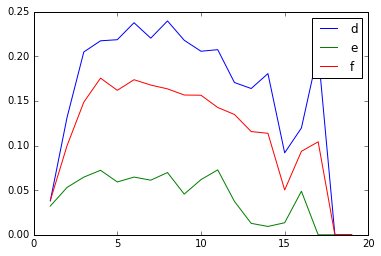

In [16]:
plt.plot(d.keys(), d.values(), d.keys(), e.values(), d.keys(), f.values())
plt.legend(['d', 'e', 'f'])

In [ ]:
# test for precision()
H = nx.DiGraph()
H.add_nodes_from([1,2,3,4,5])
H.add_edges_from([(1,2), (2,4), (3,5)])
test_edges = ([(1,2,{'score': 2}), (2,3, {'score': 1}), (3,5, {'score': 0.5}), (4,5, {'score': 0.5})])
assert precision(H, [test_edges], 1) == [1.0]
assert precision(H, [test_edges], 2) == [0.5]
assert precision(H, [test_edges], 4) == [0.5]

In [270]:
# Test for per_node_precision()
H = nx.DiGraph()
H.add_nodes_from([1,2,3,4,5,6,7])
H.add_edges_from([(1,2), (1,5), (1,3), (2,4), (2,5), (2,3), (3,5), (3,4)])
test_edges = {1: [(1,2,{'score': 2, 'n_edges': 1}), (1,6,{'score': 1, 'n_edges': 1}),
                  (1,2,{'score': 2, 'n_edges': 2}), (1,6,{'score': 2, 'n_edges': 2})],
              2: [(2,3,{'score': 2, 'n_edges': 1}), (2,4,{'score': 2, 'n_edges': 1}), (2,5,{'score': 1, 'n_edges': 1}),
                  (2,3,{'score': 2, 'n_edges': 2})],
              3: [(3,1,{'score': 2, 'n_edges': 1})]
             }
prec = per_node_precision(H, test_edges)
assert prec[1] == [0.5, 1.0, 0.0]
assert prec[2] == [1.0, 1.0]

In [278]:
# Test for triadic_distribution(), values taken from paper
H = nx.DiGraph()
H.add_nodes_from(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
H.add_edges_from([('a', 'b'), ('a', 'c'), ('a', 'd')])
H.add_edges_from([('b', 'a'), ('b', 'c')])
H.add_edges_from([('c', 'a'), ('c', 'b'), ('c', 'd')])
H.add_edges_from([('d', 'e'), ('d', 'f')])
H.add_edges_from([('e', 'f')])
H.add_edges_from([('f', 'd'), ('f', 'e'), ('f', 'g'), ('f', 'h')])
H.add_edges_from([('g', 'f')])
H.add_edges_from([('h', 'f')])
dist = triadic_distribution(H)
assert dist.pop(1) == 10
assert dist.pop(2) == 2
assert dist.pop(3) == 2
assert dist.pop(4) == 2
assert dist.pop(5) == 2
assert dist.pop(7) == 2
assert dist.pop(8) == 2
assert dist.pop(11) == 1
assert dist.pop(12) == 2
assert dist.pop(21) == 1
assert dist.pop(27) == 2
assert dist.pop(31) == 6
assert dist.pop(32) == 1
assert dist.pop(33) == 1
assert dist.pop(35) == 1
assert dist.pop(36) == 2
assert dist.pop(37) == 1
for v in dist.itervalues():
    assert v == 0

In [292]:
# Test for CommonNeighbors.valid_false_edges()
H = nx.DiGraph()
H.add_nodes_from([(1, {'date': 7}), (2, {'date': 7}),(3, {'date': 7}),(4, {'date': 7}),
                  (5, {'date': 7}),(6, {'date': 7}),(7, {'date': 7})])
H.add_edges_from([(1,2, {'date': 7}), (1,5, {'date': 7}), (1,3, {'date': 7}), (2,4, {'date': 7}), (2,5, {'date': 7}), 
                  (2,3, {'date': 7}), (3,5, {'date': 7}), (3,4, {'date': 7})])
fe = CommonNeighbors().valid_false_edges(H, H.nodes())
for (x,y, data) in fe:
    assert set(scoped_neighborhood(y,x,H)).intersection(set(scoped_neighborhood(x,x,H))) != set()
assert {(x,y) for (x,y,data) in fe}.intersection(set(H.nodes())) == set()

In [294]:
# Test for TriadicCloseness.valid_false_edges()
H = nx.DiGraph()
H.add_nodes_from([(1, {'date': 7}), (2, {'date': 7}),(3, {'date': 7}),(4, {'date': 7}),
                  (5, {'date': 7}),(6, {'date': 7}),(7, {'date': 7})])
H.add_edges_from([(1,2, {'date': 7}), (1,5, {'date': 7}), (1,3, {'date': 7}), (2,4, {'date': 7}), (2,5, {'date': 7}), 
                  (2,3, {'date': 7}), (3,5, {'date': 7}), (3,4, {'date': 7})])
fe = TriadicCloseness().valid_false_edges(H, H.nodes())
for (x,y, data) in fe:
    assert set(scoped_neighborhood(y,x,H)).intersection(set(scoped_neighborhood(x,x,H))) != set()
assert {(x,y) for (x,y,data) in fe}.intersection(set(H.nodes())) == set()

In [ ]:
# Test for CommonReferrers.valid_false_edges()
H = nx.DiGraph()
H.add_nodes_from([(1, {'date': 7}), (2, {'date': 7}),(3, {'date': 7}),(4, {'date': 7}),
                  (5, {'date': 7})])
H.add_edges_from([(1,2, {'date': 7}), (1,5, {'date': 7}), (3,2, {'date': 7}), (3,4, {'date': 7}), (3,5, {'date': 7})])
fe = CommonReferrers().valid_false_edges(H, H.nodes())
for (x,y, data) in fe:
    neighbors = successors_scoped(x,x,H)
    referrers = predecessors_scoped(y,x,H)
    z = set([ref for neighbor in neighbors for ref in predecessors_scoped(neighbor,x,H)]) - {x}
    assert z & set(referrers) != set()
assert {(x,y) for (x,y,data) in fe}.intersection(set(H.nodes())) == set()

In [369]:
# Test for CommonRefferers.score_edges()
validation_set = H.edges(data=True) + [(5,2,{'date': 7}), (1,4,{'date': 7})]
CommonReferrers().score_edges(validation_set, H)

[(1, 2, {'date': 7, 'score': 1}),
 (1, 5, {'date': 7, 'score': 1}),
 (3, 2, {'date': 7, 'score': 1}),
 (3, 4, {'date': 7, 'score': 0}),
 (3, 5, {'date': 7, 'score': 1}),
 (5, 2, {'date': 7, 'score': 0}),
 (1, 4, {'date': 7, 'score': 1})]

In [361]:
x = 3
y = 5
successors_scoped(x, x, H)
s = set()
for m in successors_scoped(x,x,H):
    s = s | set(predecessors_scoped(m,x,H))

In [367]:
{n for m in successors_scoped(x, x, H) for n in predecessors_scoped(m, x, H)} - {x}

{1}

In [348]:
{n for n in (set(predecessors_scoped(5,x,H)) - {x})}

{1}

In [298]:
fe

[(1, 4, {'date': 7})]

In [239]:
true_positives = [[(edge[0],edge[1]) for edge in result[0:1] if (edge[0], edge[1]) in edge_set] for result in results]

In [249]:
precision(H, [test_edges], 1)

[1.0]

In [142]:
m = 43
s = {n: {k: [] for k in range(1,m+1)} for n in r.iterkeys()}
for node, node_res in r.iteritems():
    srt = sorted(node_res, key=lambda x: x[2]['score'], reverse=True)
    for x,y,data in srt:
        if not s[node][data['n_edges']]:
            s[node][data['n_edges']] = []
        s[node][data['n_edges']].append((x,y,{'score': data['score']}))

In [143]:
precisions = {k: [] for k in range(1,m+1)}
edge_set = set(GCC.edges())
for node, node_res in s.iteritems():
    n = GCC.degree(node)
    for level, results in node_res.iteritems():
        L = n-level
        if len(results) == 0:
            break
        precisions[level].append(1.0*len([(edge[0],edge[1]) for edge in results[0:L] if (edge[0], edge[1]) in edge_set])/L)


In [265]:
a = per_node_precision(GCC, cn)
b = per_node_precision(GCC, cr)
c = per_node_precision(GCC, tc)
d = {k: sum(p)/len(p) for k,p in a.iteritems() if len(p) != 0}
e = {k: sum(p)/len(p) for k,p in b.iteritems() if len(p) != 0}
f = {k: sum(p)/len(p) for k,p in c.iteritems() if len(p) != 0}

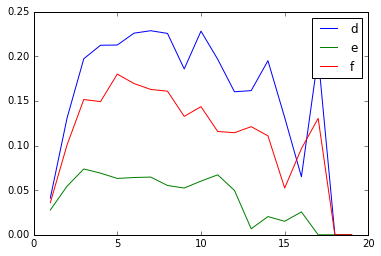

In [266]:
plt.plot(d.keys(), d.values(), d.keys(), e.values(), d.keys(), f.values())
plt.legend(['d', 'e', 'f'])

To check whether my implementation of the triadic census is correct I'll verify it with the graph presented by Schall

In [ ]:
H = nx.DiGraph()
H.add_nodes_from(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
H.add_edges_from([('a', 'b'), ('a', 'c'), ('a', 'd')])
H.add_edges_from([('b', 'a'), ('b', 'c')])
H.add_edges_from([('c', 'a'), ('c', 'b'), ('c', 'd')])
H.add_edges_from([('d', 'e'), ('d', 'f')])
H.add_edges_from([('e', 'f')])
H.add_edges_from([('f', 'd'), ('f', 'e'), ('f', 'g'), ('f', 'h')])
H.add_edges_from([('g', 'f')])
H.add_edges_from([('h', 'f')])
dist = triadic_distribution(H)
filter(lambda x: x[1] != 0, sorted(dist.items(), key=lambda x: x[1], reverse=True))

Seems like it matches!

In [ ]:
%time dist = triadic_distribution(GCC)

In [ ]:
H = nx.DiGraph()

In [ ]:
H.add_nodes_from([('a', {'date': 2}), ('b', {'date': 2}), ('c', {'date': 2}), ('d', {'date': 2}), ('e', {'date': 2})])

In [ ]:
%matplotlib inline
H.add_edges_from([('a', 'b'), ('a', 'e'), ('a', 'c'), ('c','e'), ('c', 'b'), ('c', 'd'), ('e', 'd')])
nx.draw(H, with_labels=True)

In [ ]:
AdamicAdar().score_edges([('a', 'c', {'date': 3})], H)

In [ ]:
AdamicAdar().valid_false_edges(H, ['e'])

In [ ]:
hh[1] = 10

In [ ]:
hh

In [ ]:
math.log(scoped_in_degree('e', 'a', H))

In [ ]:
u = H.nodes()[1]
z = H.neighbors(u)[2]
v = H.neighbors(z)[0]
u_in = set(H.predecessors(u))
v_in = set(H.predecessors(v))
z_in = set(H.predecessors(z))
u_out = set(H.successors(u))
v_out = set(H.successors(v))
z_out = set(H.successors(z))
id = 0
print u, z, v

In [216]:
fe=AdamicAdar().valid_false_edges(GCC, GCC.nodes())

In [217]:
{(x,y) for x,y,data in fe}.intersection(set(GCC.edges()))

set()

In [219]:
dir()

['AUC',
 'AdamicAdar',
 'Callable',
 'CommonNeighbors',
 'CommonReferrers',
 'Container',
 'Counter',
 'G',
 'GCC',
 'Hashable',
 'In',
 'ItemsView',
 'Iterable',
 'Iterator',
 'Jaccard',
 'KeysView',
 'L',
 'LeichHolmeNewman',
 'Mapping',
 'MappingView',
 'MutableMapping',
 'MutableSequence',
 'MutableSet',
 'OrderedDict',
 'Out',
 'ResourceAllocation',
 'Sequence',
 'Set',
 'Sized',
 'TriadicCloseness',
 'ValuesView',
 '_',
 '_10',
 '_113',
 '_126',
 '_127',
 '_131',
 '_132',
 '_134',
 '_135',
 '_136',
 '_14',
 '_140',
 '_145',
 '_150',
 '_151',
 '_155',
 '_160',
 '_161',
 '_162',
 '_164',
 '_166',
 '_169',
 '_174',
 '_175',
 '_177',
 '_191',
 '_20',
 '_206',
 '_207',
 '_211',
 '_213',
 '_215',
 '_217',
 '_22',
 '_23',
 '_26',
 '_27',
 '_28',
 '_42',
 '_49',
 '_64',
 '_69',
 '_7',
 '_70',
 '_71',
 '_72',
 '_73',
 '_75',
 '_77',
 '_78',
 '_8',
 '_86',
 '_9',
 '_95',
 '_96',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__name__',
 '__nonzero__',
 '__package__',
 '_dh',

In [220]:
s = []

3

In [ ]:
get_triad('a', 'd', 'c', H)

In [ ]:
%time cr_results = k_fold_validate(GCC, 5, common_referrers)

In [ ]:
print "CR:"
print sum(precision(GCC, cr_results, 50))/5
print sum(AUC(GCC, cr_results))/5

In [ ]:
%time cn_results = k_fold_validate(GCC, 5, common_neighbors)

In [ ]:
print "CR:"
print sum(precision(GCC, cn_results, 50))/5
print sum(AUC(GCC, cn_results))/5

In [ ]:
%time nx.triadic_census(GCC)

In [ ]:
c = 0
f = 0
for node in GCC.nodes_iter():
    for n in GCC.neighbors(node):
        nei = GCC.neighbors(n)
        if node in nei:
            c+= 1
            if GCC.node[node]['date'] != GCC.node[n]['date']:
                f+=1


In [ ]:
n1 = GCC.nodes()[1234]
n2 = GCC.nodes()[4321]

In [ ]:
s = set(GCC.predecessors(n1)) | set(GCC.successors(n1)) | set(GCC.predecessors(n2)) | set(GCC.successors(n2)) | set([n1, n2])

In [ ]:
n1

In [ ]:
    TRIAD_NAMES = range(1,10) + range(11, 20) + range(21,30)
    census = {name: 0 for name in TRIAD_NAMES}


In [ ]:
census[1]

In [ ]:
H.add_edge(n1,n2)

In [ ]:
nx.triadic_census(H)

In [ ]:
GCC[n1]

In [ ]:
set(GCC.predecessors(n1)) | set(GCC.successors(n1))

In [ ]:
set(H.predecessors(n1)) | set(H.successors(n1))

In [ ]:
%pdb